# Attempting to fit flux time series to various characteristical curves and use their coeffs as features

### Generation of features

Already implemented in featurize.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Set
from datetime import datetime as dt

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate
from plasticc.final import featurize_test, predict_test

Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [5]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [6]:
%%time
meta_train = process_meta('../../data/raw/training_set_metadata.csv')
train = pd.read_csv('../../data/raw/training_set.csv')

CPU times: user 1.51 s, sys: 124 ms, total: 1.63 s
Wall time: 1.63 s


In [7]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=16)

Generating custom features...
Custom features generated.


Feature Extraction: 100%|██████████| 80/80 [00:01<00:00, 61.84it/s]


CPU times: user 1min 53s, sys: 1.84 s, total: 1min 55s
Wall time: 1min 55s


In [8]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [9]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 18.2 ms


In [10]:
X.shape

(7848, 156)

In [11]:
y.shape

(7848,)

### Train model with CV

In [12]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 6,
    'n_estimators': 2048,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.02137,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.126,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 32,
    'min_data_in_leaf': 13,
    'lambda_l1': 2,
}

In [13]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf',
])
colnames_to_ignore_restrictive = colnames_to_ignore | set([
    'latlon1',
    'haversine',
])
colnames_to_ignore_very_restrictive = colnames_to_ignore_restrictive | set([
    'flux_err_skew',
    'flux_by_flux_ratio_sq_sum'
])

colanmes_to_ignore_no_raw_data_peaks = colnames_to_ignore_very_restrictive | set([col for col in X.columns if 'peak' in col and not 'period' in col])

id_colname = 'object_id'

In [14]:
feature_colnames = [col for col in X.columns if col not in colanmes_to_ignore_no_raw_data_peaks]

In [15]:
%%time
clfs, score, importances = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params={
        'lgbm': lgbm_params
    }, 
    nr_fold=6, 
    random_state=1
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.411538	training's wloss: 0.922536	valid_1's multi_logloss: 1.81173	valid_1's wloss: 1.11375
[200]	training's multi_logloss: 0.209196	training's wloss: 0.598647	valid_1's multi_logloss: 1.39742	valid_1's wloss: 0.816517
[300]	training's multi_logloss: 0.147966	training's wloss: 0.468474	valid_1's multi_logloss: 1.20549	valid_1's wloss: 0.715734
[400]	training's multi_logloss: 0.118627	training's wloss: 0.394423	valid_1's multi_logloss: 1.09358	valid_1's wloss: 0.674944
[500]	training's multi_logloss: 0.100653	training's wloss: 0.346039	valid_1's multi_logloss: 1.02266	valid_1's wloss: 0.659654
[600]	training's multi_logloss: 0.0879252	training's wloss: 0.309629	valid_1's multi_logloss: 0.970354	valid_1's wloss: 0.650775
[700]	training's multi_logloss: 0.0779331	training's wloss: 0.280309	valid_1's multi_logloss: 0.928927	valid_1's wloss: 0.643838
[800]	training's multi_logloss: 0.0698171	tra

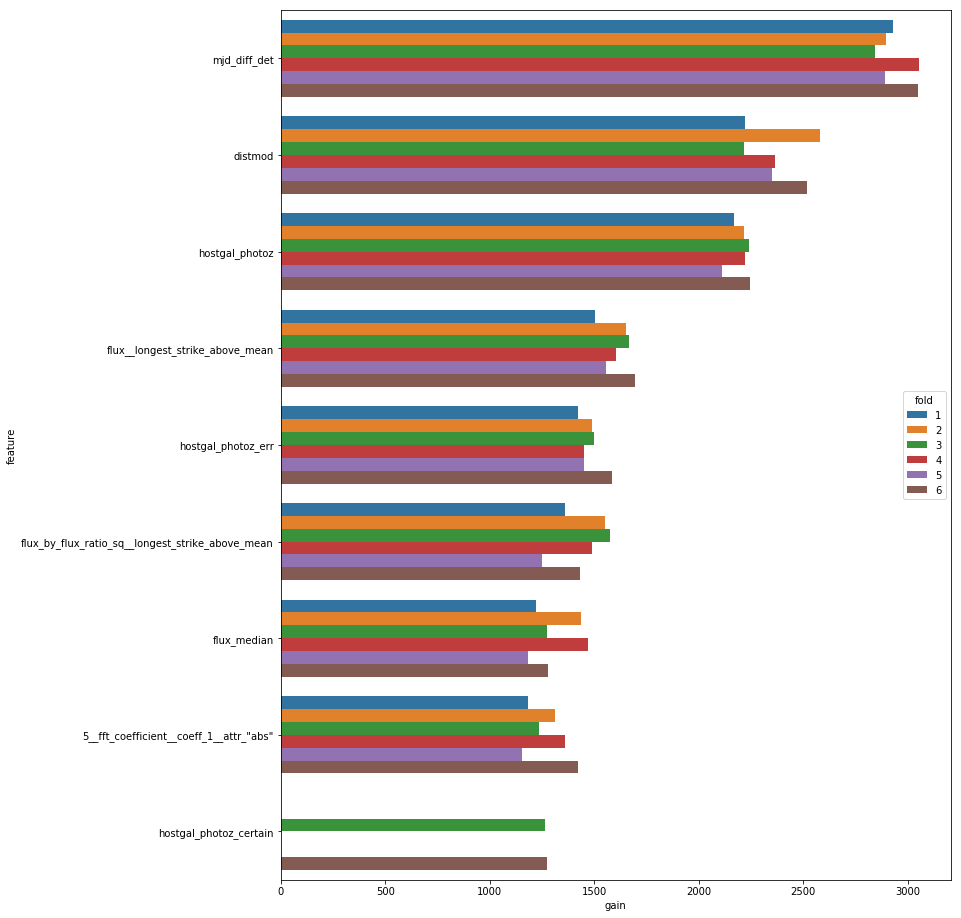

In [16]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).head(50), x='gain', y='feature', hue='fold', )
plt.show()

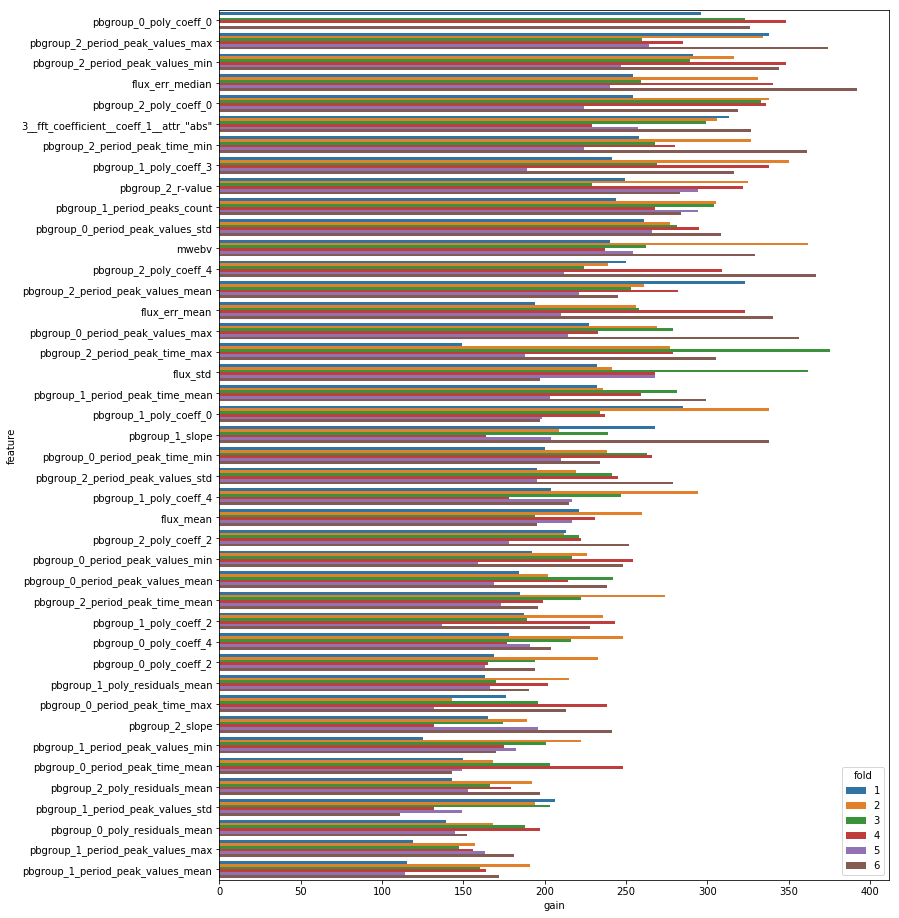

In [17]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).tail(250), x='gain', y='feature', hue='fold', )
plt.show()

### Combine multiple test features CSVs into one

In [37]:
import os
from tqdm.autonotebook import tqdm

In [38]:
!ls ../../data/features/

test-3band-series-models-without-kernel-features-0.csv
test-3band-series-models-without-kernel-features-1.csv
test-3band-series-models-without-kernel-features-2.csv
test-3band-series-models-without-kernel-features-3.csv
test-3band-series-models-without-kernel-features-4.csv
test-3band-series-models-without-kernel-features-missed.csv


In [39]:
csv_dir = '../../data/features/'
csv_paths = [os.path.abspath(os.path.join(csv_dir, fname)) for fname in os.listdir(csv_dir) if not fname.startswith('.')]

In [40]:
%%time
csvs = [pd.read_csv(path) for path in csv_paths]

CPU times: user 59.8 s, sys: 2.22 s, total: 1min 2s
Wall time: 1min 1s


In [41]:
len(csvs)

6

In [42]:
csvs[0].shape

(673664, 88)

In [43]:
csvs[-1].shape

(35434, 88)

Append missing column that was stored in index:

In [44]:
%%time
full_new_features = pd.concat(csvs, ignore_index=True)

CPU times: user 444 ms, sys: 668 ms, total: 1.11 s
Wall time: 1.11 s


In [45]:
print("Done")

Done


In [46]:
%%time
full_new_features['object_id'] = full_new_features['Unnamed: 0']
del full_new_features['Unnamed: 0']

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 15.4 ms


In [47]:
%%time
full_new_features = full_new_features.sort_values(by='object_id')

CPU times: user 696 ms, sys: 2.84 s, total: 3.54 s
Wall time: 3.53 s


In [48]:
full_new_features['object_id'].head()

2211709    13
2211710    14
2211711    17
2211712    23
2211713    34
Name: object_id, dtype: int64

In [49]:
full_new_features['object_id'].tail()

850916     130787966
850917     130787971
850918     130787974
850919     130788053
1573637    130788054
Name: object_id, dtype: int64

In [50]:
%%time
full_new_features.index = full_new_features['object_id']
del full_new_features['object_id']
full_new_features.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.45 ms


In [51]:
full_new_features.head()

,pbgroup_0_peak_time_min,pbgroup_0_peak_time_max,pbgroup_0_peaks_count,pbgroup_0_peak_time_mean,pbgroup_0_peak_values_min,pbgroup_0_peak_values_max,pbgroup_0_peak_values_mean,pbgroup_0_peak_values_std,pbgroup_0_period_peak_time_min,pbgroup_0_period_peak_time_max,...,pbgroup_2_p-value,pbgroup_2_stderr,pbgroup_2_poly_coeff_0,pbgroup_2_poly_coeff_1,pbgroup_2_poly_coeff_2,pbgroup_2_poly_coeff_3,pbgroup_2_poly_coeff_4,pbgroup_2_poly_residuals_min,pbgroup_2_poly_residuals_max,pbgroup_2_poly_residuals_mean
object_id,,,,,,,,,,,,,,,,,,,,,
13,-0.992874,0.981018,37.0,-0.009123,-0.776626,23.404964,2.680370,3.922883,101.0,329.0,...,1.565440e-19,1.195247,-72.644434,-57.657323,80.159762,59.604606,-2.194671,2823.946387,2823.946387,2823.946387
14,-0.950966,0.988048,41.0,0.077872,-0.914986,6.371965,1.807047,1.879649,241.0,241.0,...,1.262598e-04,0.601631,14.347083,3.965887,-20.788443,-2.661531,4.551678,1786.159305,1786.159305,1786.159305
17,-0.933843,0.981267,34.0,0.172996,-0.350579,11.756248,2.665418,2.447568,143.0,143.0,...,1.687390e-05,0.662176,5.497920,-3.505778,-4.527032,4.004490,3.146736,2876.061444,2876.061444,2876.061444
23,-0.953262,0.985706,40.0,0.016283,-1.544409,5.278965,1.582027,1.516550,372.0,372.0,...,6.209115e-01,0.894579,-68.268036,4.373502,103.137440,-12.938790,-36.352756,2651.705777,2651.705777,2651.705777
34,-0.961360,0.993060,38.0,0.113114,-0.899885,69.579277,3.959572,11.111745,182.0,372.0,...,4.730776e-01,2.796408,358.623135,7.010582,-546.573715,-20.009836,200.543071,34979.758421,34979.758421,34979.758421


##### Prepare to join with previous features

In [26]:
%%time
df_kernel = pd.read_csv('../../data/test-all-feat-from-kernel-repro.csv')

CPU times: user 44.6 s, sys: 2.27 s, total: 46.9 s
Wall time: 46.9 s


In [52]:
set(df_kernel['object_id']) == set(full_new_features.index)

True

In [28]:
missing_ids = sorted(list(set(df_kernel['object_id'].unique()) - set(full_new_features.index)))

In [29]:
missing_ids[:10]

[103524116,
 103524119,
 103524138,
 103524346,
 103524360,
 103524395,
 103524430,
 103524448,
 103524556,
 103524557]

In [30]:
missing_ids[-10:]

[104853513,
 104853523,
 104853556,
 104853595,
 104853622,
 104853625,
 104853653,
 104853684,
 104853725,
 104853738]

##### WARNING: There are missing IDs, we need to inspect where the leak happend and find errors:

Generating missing features

In [31]:
missing_ids = set(missing_ids)

In [32]:
chunks = 4536532
test_path = '../../data/raw/test_set.csv'
output_path = '../../data/features/test-3band-series-models-without-kernel-features-missed.csv'
id_colname = 'object_id'

In [33]:
from plasticc.featurize import *
import gc
gc.enable()

In [34]:
%%time

remain_df = None
saved = 0
for i_c, df in tqdm(enumerate(pd.read_csv(test_path, chunksize=chunks, iterator=True)), total=100):
    unique_ids = np.unique(df[id_colname])
    new_remain_df = df.loc[df[id_colname] == unique_ids[-1]].copy()
    if remain_df is None:
        df = df.loc[df[id_colname].isin(unique_ids[:-1])]
    else:
        df = pd.concat([remain_df, df.loc[df[id_colname].isin(unique_ids[:-1])]], axis=0)
    # Create remaining samples df
    remain_df = new_remain_df

    missing_only = df[df['object_id'].apply(lambda x: x in missing_ids)]
    if len(missing_only) == 0:
        continue
    
    preprocessed_df = preprocess_series(missing_only)
    del df  # preprocess series copies the dataframe so we can safely delete it
    gc.collect()

    gbo = preprocessed_df.groupby('object_id')
    group_features_series = [process_group(g) for g in gbo]
    series_features_df = pd.concat(group_features_series, axis=1).transpose()
    if saved == 0:
        series_features_df.to_csv(output_path, header=True, mode='w', index=True)
        saved = saved + 1
    else:
        series_features_df.to_csv(output_path, header=False, mode='a', index=True)
        saved = saved + 1

missing_only = remain_df[remain_df['object_id'].apply(lambda x: x in missing_ids)]
if len(missing_only) > 0:
    preprocessed_df = preprocess_series(missing_only)
    del df  # preprocess series copies the dataframe so we can safely delete it
    gc.collect()

    gbo = preprocessed_df.groupby('object_id')
    group_features_series = [process_group(g) for g in gbo]
    series_features_df = pd.concat(group_features_series, axis=1).transpose()
    if saved == 0:
        series_features_df.to_csv(output_path, header=True, mode='w', index=True)
        saved = saved + 1
    else:
        series_features_df.to_csv(output_path, header=False, mode='a', index=True)
        saved = saved + 1


CPU times: user 13min, sys: 26.8 s, total: 13min 27s
Wall time: 13min 59s


In [36]:
print("Done")

Done


Go back, reload array of CSVs and check whether indices match this time (they should)

##### Perform the actual join

In [53]:
%%time
df_full_feat = df_kernel.join(full_new_features, on='object_id')

CPU times: user 2.16 s, sys: 4.18 s, total: 6.34 s
Wall time: 6.33 s


In [55]:
df_full_feat.shape

(3492890, 156)

In [56]:
df_full_feat.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,...,pbgroup_2_p-value,pbgroup_2_stderr,pbgroup_2_poly_coeff_0,pbgroup_2_poly_coeff_1,pbgroup_2_poly_coeff_2,pbgroup_2_poly_coeff_3,pbgroup_2_poly_coeff_4,pbgroup_2_poly_residuals_min,pbgroup_2_poly_residuals_max,pbgroup_2_poly_residuals_mean
0,13,-12.680235,42.765503,3.997127,0.616561,9.149645,2.037355,0.691634,11.257108,2.461810,...,1.565440e-19,1.195247,-72.644434,-57.657323,80.159762,59.604606,-2.194671,2823.946387,2823.946387,2823.946387
1,14,-11.142164,14.839427,0.884047,0.072856,3.399946,0.970525,0.690589,11.249375,2.457580,...,1.262598e-04,0.601631,14.347083,3.965887,-20.788443,-2.661531,4.551678,1786.159305,1786.159305,1786.159305
2,17,-14.202744,16.761280,0.791032,0.458390,3.886578,0.377131,0.663680,11.278636,2.702947,...,1.687390e-05,0.662176,5.497920,-3.505778,-4.527032,4.004490,3.146736,2876.061444,2876.061444,2876.061444
3,23,-12.631923,28.061138,0.970396,0.465986,4.100713,2.177402,0.697639,11.305429,2.480364,...,6.209115e-01,0.894579,-68.268036,4.373502,103.137440,-12.938790,-36.352756,2651.705777,2651.705777,2651.705777
4,34,-13.239577,124.475609,4.580070,0.301366,19.862714,4.537527,0.679312,11.365292,2.746784,...,4.730776e-01,2.796408,358.623135,7.010582,-546.573715,-20.009836,200.543071,34979.758421,34979.758421,34979.758421


In [ ]:
%%time
df_full_feat.to_csv('../../data/test-new-poly-with-kernel.csv', index=False)

In [61]:
print("Done")

Done


### Generate predictions on the test set

In [18]:
submission_file_path = path_from_cv_score(score)
submission_file_path

'/home/kk385830/astronomical-classification/submissions/subm_0.603058_2018-12-16-18-13.csv'

In [21]:
%%time
submission = predict_test(
    clfs=clfs, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    input_path='../../data/test-new-poly-with-kernel.csv', 
    output_path=submission_file_path, 
    class_99_target_mean=0.12,
    verbose=True
)

Loading data...


  0%|          | 0/6 [00:00<?, ?it/s]

Generating predictions...


100%|██████████| 6/6 [15:53<00:00, 165.67s/it]


Postprocessing...
Submission shape before grouping: (3492890, 16)
Submission shape after grouping: (3492890, 15)
Submission shape after postprocessing: (3492890, 15)
Validating submission file...
Saving submission...
Submission saved to f/home/kk385830/astronomical-classification/submissions/subm_0.603058_2018-12-16-18-13.csv
CPU times: user 3h 50min 6s, sys: 1min 25s, total: 3h 51min 32s
Wall time: 19min 19s


In [27]:
submission.head(3)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000037,0.000326,0.000023,0.329773,0.349760,0.000057,0.046689,0.000017,0.000017,0.001120,0.000065,0.053622,0.000030,0.000247,0.218217
14,0.000057,0.002647,0.000052,0.108428,0.031220,0.000084,0.029663,0.000070,0.000304,0.014973,0.000214,0.641568,0.000054,0.013706,0.156958
17,0.000141,0.004441,0.000137,0.081695,0.050664,0.000184,0.014805,0.001838,0.000203,0.091125,0.001432,0.537216,0.000070,0.024835,0.191213


In [51]:
submission['class_99'].mean()

0.13013586

In [52]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000040,0.000354,0.000024,0.357446,0.379110,0.000061,0.050607,0.000019,0.000019,0.001214,0.000070,0.058122,0.000033,0.000267,0.152613
14,0.000060,0.002804,0.000055,0.114822,0.033061,0.000089,0.031412,0.000075,0.000322,0.015856,0.000227,0.679401,0.000058,0.014515,0.107244
17,0.000151,0.004765,0.000147,0.087640,0.054351,0.000197,0.015882,0.001972,0.000218,0.097757,0.001537,0.576313,0.000076,0.026642,0.132353
23,0.000080,0.001103,0.000092,0.054336,0.013861,0.000125,0.050159,0.006378,0.000147,0.186823,0.000155,0.508671,0.000044,0.033623,0.144404
34,0.000018,0.000605,0.000017,0.040403,0.162473,0.000038,0.012966,0.000023,0.000040,0.004567,0.000024,0.669535,0.000014,0.000119,0.109158


### Quick check reny entropy mean class 99 probabilities

In [12]:
submission = pd.read_csv('../../submissions/subm_0.603058_2018-12-16-18-13.csv', index_col='object_id')

In [13]:
def renyEntropy(alpha, vector):
    if alpha < 0 or alpha == 1:
        raise Exception('alpha must not be 1 neither negative')

    coeff = 1 / (1 - alpha)
    powered = vector ** alpha
    sumpow = np.sum(powered, axis=1)
    logof = np.log(sumpow) / np.log(13)
    return logof * coeff

In [14]:
reny_99 = renyEntropy(10, submission.values) * 0.25

In [15]:
submission['class_99'] = (submission['class_99'].values + reny_99) / 2

In [16]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000040,0.000354,0.000024,0.357446,0.379110,0.000061,0.050607,0.000019,0.000019,0.001214,0.000070,0.058122,0.000033,0.000267,0.126435
14,0.000060,0.002804,0.000055,0.114822,0.033061,0.000089,0.031412,0.000075,0.000322,0.015856,0.000227,0.679401,0.000058,0.014515,0.074553
17,0.000151,0.004765,0.000147,0.087640,0.054351,0.000197,0.015882,0.001972,0.000218,0.097757,0.001537,0.576313,0.000076,0.026642,0.096018
23,0.000080,0.001103,0.000092,0.054336,0.013861,0.000125,0.050159,0.006378,0.000147,0.186823,0.000155,0.508671,0.000044,0.033623,0.108804
34,0.000018,0.000605,0.000017,0.040403,0.162473,0.000038,0.012966,0.000023,0.000040,0.004567,0.000024,0.669535,0.000014,0.000119,0.076302


In [17]:
submission.sum(axis=1).head()

object_id
13    0.973822
14    0.967309
17    0.963665
23    0.964400
34    0.967144
dtype: float64

In [18]:
# normalization - all classes' probabilities should be equal to 1.0 for each object_id
subm_sum = submission.sum(axis=1)
for col in submission.columns:
    submission[col] = submission[col] / subm_sum
max_err = np.max(np.abs(submission.sum(axis=1).values - 1.0))
if max_err > 1e-7:
    print(f"Warning: high error in submission normalization: {max_err}")
# round all predictions to float32 so that CSV is twice smaller (Kaggle uses 32-bit accuracy to calculate score anyway)
submission = submission.round(decimals=8).astype(np.float32)
# make sure index is typed correctly
submission.index = submission.index.astype(np.int)
print(f"Submission shape after postprocessing: {submission.shape}")

Submission shape after postprocessing: (3492890, 15)


In [19]:
submission.to_csv('../../submissions/subm_0.603058_2018-12-16-18-13_quarter_reny_with_previous_99_avg.csv')

In [21]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000041,0.000363,0.000025,0.367055,0.389301,0.000063,0.051967,0.000019,0.000019,0.001247,0.000072,0.059684,0.000034,0.000275,0.129834
14,0.000062,0.002898,0.000057,0.118703,0.034178,0.000092,0.032474,0.000077,0.000332,0.016392,0.000235,0.702363,0.000060,0.015005,0.077073
17,0.000157,0.004944,0.000153,0.090945,0.056401,0.000205,0.016481,0.002046,0.000226,0.101443,0.001595,0.598042,0.000078,0.027647,0.099638
23,0.000083,0.001144,0.000096,0.056342,0.014372,0.000129,0.052011,0.006613,0.000152,0.193720,0.000160,0.527448,0.000046,0.034865,0.112820
34,0.000018,0.000626,0.000018,0.041776,0.167992,0.000039,0.013406,0.000024,0.000041,0.004722,0.000025,0.692281,0.000015,0.000123,0.078894


In [23]:
submission['class_99'].mean()

0.10975695